考虑 ATR10 / ATR60. 因为与短期高点有显著正相关。

last_top，原因同上

使用斯皮尔曼相关系数

是否应该允许同一高点多次突破？

In [1]:
from analysis_utils import *
from utils import date_to_milliseconds
pd.set_option('display.max_columns', None)

<Figure size 1000x500 with 0 Axes>

In [2]:
usd_name = 'TUSD'
token_name = 'BTC'
is_futures = False
symbol = token_name + usd_name
sim_data = get_combined_data(symbol, '+0_5-3atr10_bias0_1', 1683750540000, 1687950539999, is_futures, confirm_step=3)
sim_data_info = read_data(symbol, '+0_5-3atr10_bias0_1', 1683750540000, 1687950539999, is_futures)
print(f"data length = {len(sim_data)}")

buy_p    = sim_data_info.buy_points
sell_p   = sim_data_info.sell_points

sim_data['buy_price'] = np.nan
sim_data['sell_price'] = np.nan

j = 0
for i in range(len(sim_data)):
    if sim_data['open_time'][i] == buy_p.idx[j]:
        # Record these info on the preview step of the actually traded step
        idx = sim_data.index[i]-1
        sim_data.loc[idx, 'buy_price'] = buy_p.value[j]
        sim_data.loc[idx, 'hold_step'] = (sell_p.idx[j] - buy_p.idx[j]) // 60000
        sim_data.loc[idx, 'sell_price'] = sell_p.value[j]
        sim_data.loc[idx, 'earn'] = (sell_p.value[j] - buy_p.value[j]) / buy_p.value[j]
        
        j += 1
        if j >= len(sell_p.idx):
            break

# sim_data[sim_data['buy_price'].isnull() == False].head()

data length = 70000


In [3]:
total_num = sum(sim_data['buy_price'].isnull() == False)
print(f"Total: {total_num}")
earn_num = sum(sim_data['earn'] > 0)
print(f"Earn rate: {earn_num / total_num * 100 :.2f}%")
print(f"Average earn: {sim_data[sim_data['buy_price'].isnull() == False]['earn'].mean() * 100 :.4f}%")

Total: 2933
Earn rate: 86.87%
Average earn: 0.0017%


In [4]:
target = Target(target_step=3, steps=[3])
full_data = FeatData(sim_data, target)

# Drop useless features
full_data.drop_features(
   ['close_time', 'volume', 'taker_buy_volume', 'open_time', 'buy_price', 'sell_price'])

full_data.set_features_type(['hold_step'], FeatTypes.OTHERS)
full_data.set_features_type(['earn'], FeatTypes.TARGET)
full_data.add_feature('is_earn', FeatTypes.TARGET, lambda df: df['earn'].apply(lambda x: 1 if x > 0 else 0))

full_data.add_feature('max_after_top', FeatTypes.TARGET, lambda df: 
                      (df['high'].rolling(3).max().shift(-3) - df['last_top']) / df['close']) # / df['close']  
full_data.add_feature('min_after_top', FeatTypes.TARGET, lambda df: 
                      (df['low'].rolling(2).min().shift(-3) - df['last_top']) / df['close'])  

full_data.add_feature('TR', FeatTypes.TR, lambda df: df['high'] - df['low'] + 0.001)   # Incase TR is 0
full_data.add_feature('ER', FeatTypes.OTHERS, lambda df: (df['close'] - df['open']) / df['TR'])

full_data.add_feature('lastlast_top', FeatTypes.PRICE, lambda df: df['last_top'].shift(1))

def add_ll_bottom(df: pd.DataFrame):
   col = df['last_bottom'].shift(1)
   down_idx = df[df['is_up'] == 0].index
   col.loc[down_idx] = df['last_bottom']
   return col

full_data.add_feature('lastlast_bottom', FeatTypes.PRICE, lambda df: add_ll_bottom(df))

# 单位波动的成交额 -> 无效
# full_data.add_feature('volume/TR', FeatTypes.VOL_TR, lambda df: df['quote_assert_volume'] * df['close'] / df['TR'])
full_data.drop_features(['quote_assert_volume', 'taker_buy_quote_asset_volume'])

# Add features
add_ave_features(full_data, cycles = [3, 10, 60, 300], feat_names=['close', 'TR'])
add_ave_features(full_data, cycles = [3, 10, 60, 300], feat_names=['ER'], new_ave_of_base={'AER': ['ER', FeatTypes.OTHERS]})

fast_period = 10 
slow_period = 60
signal_period = 30
# add_macd(full_data, 'close', FeatTypes.DPRICE, fast_period, slow_period, signal_period)
# add_macd(full_data, 'TR', FeatTypes.TR, fast_period, slow_period, signal_period)

# Standardization
full_data.std()

# Drop na at last
full_data.drop_na()

full_data.df.head()

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,hold_step,earn,earn_after_3,is_earn,max_after_top,min_after_top,ER,lastlast_top,lastlast_bottom,MA3,MA10,MA60,MA300,ATR3,ATR10,ATR60,ATR300,AER3,AER10,AER60,AER300
314,0.999745,1.000017,0.999642,0.000375,1.000051,3.0,0.997184,10.0,0.0,7.0,0.0,0.000269,-0.000389,1,0.000635,-0.000580,0.678851,1.001215,0.997184,0.999880,0.999475,0.999218,1.001582,0.000442,0.000536,0.000747,0.001000,0.228671,0.262959,0.068217,-0.003255
325,0.999401,1.000005,0.999384,0.000621,1.000969,10.0,0.998927,4.0,1.0,6.0,1.0,0.000310,0.001043,1,0.000409,-0.000328,0.963729,1.000969,0.998927,0.999647,0.999660,0.999797,1.001412,0.000496,0.000619,0.000639,0.000993,0.350747,-0.027674,0.041494,-0.001152
344,0.999728,1.000132,0.999688,0.000444,1.000268,4.0,0.999204,7.0,0.0,3.0,0.0,0.000295,0.001367,1,0.001099,0.000204,0.612378,1.000268,0.999204,0.999909,0.999827,0.999915,1.000736,0.000526,0.000589,0.000678,0.000985,0.216498,-0.036003,0.029926,0.007880
418,0.999104,1.000137,0.998596,0.001541,1.000312,7.0,0.997586,11.0,0.0,4.0,9.0,0.000476,-0.000032,1,0.000363,-0.000375,0.581310,1.000312,0.997586,0.999518,0.999494,1.001771,1.004315,0.001026,0.000950,0.000825,0.000810,0.150159,-0.046732,-0.124715,-0.013683
433,0.999967,1.000027,0.999855,0.000172,1.000109,4.0,0.997767,8.0,0.0,4.0,21.0,0.000286,0.000012,1,0.000042,-0.000745,0.192348,1.000109,0.997767,0.999856,0.999386,0.999878,1.003063,0.000424,0.000572,0.000816,0.000791,0.221597,0.301607,-0.076562,-0.013112


In [5]:
price_feats  = set(full_data.cols_of_features([FeatTypes.PRICE]))
dprice_feats = set(full_data.cols_of_features([FeatTypes.DPRICE]))
tr_feats     = set(full_data.cols_of_features([FeatTypes.TR]))
vol_feats    = set(full_data.cols_of_features([FeatTypes.VOLUME]))
voltr_feats  = set(full_data.cols_of_features([FeatTypes.VOL_TR]))
tn_feats     = set(full_data.cols_of_features([FeatTypes.TRADE_NUM]))
print(f"price_feats: {price_feats}\n\
        dprice_feats: {dprice_feats}\n\
        tr_feats: {tr_feats}\n\
        vol_feats: {vol_feats}\n\
        voltr_feats: {voltr_feats}\n\
        tn_feats: {tn_feats}")
print(f"{set(full_data.df.columns) - price_feats - dprice_feats - tr_feats - vol_feats - tn_feats}")

price_feats: {'low', 'MA10', 'MA60', 'MA3', 'lastlast_bottom', 'last_top', 'MA300', 'lastlast_top', 'open', 'high', 'last_bottom'}
        dprice_feats: set()
        tr_feats: {'TR', 'ATR60', 'ATR10', 'ATR3', 'ATR300'}
        vol_feats: set()
        voltr_feats: set()
        tn_feats: set()
{'AER10', 'earn', 'is_earn', 'step_after_top', 'hold_step', 'is_up', 'earn_after_3', 'AER300', 'min_after_top', 'step_after_bottom', 'cycle_step', 'AER60', 'max_after_top', 'ER', 'AER3'}


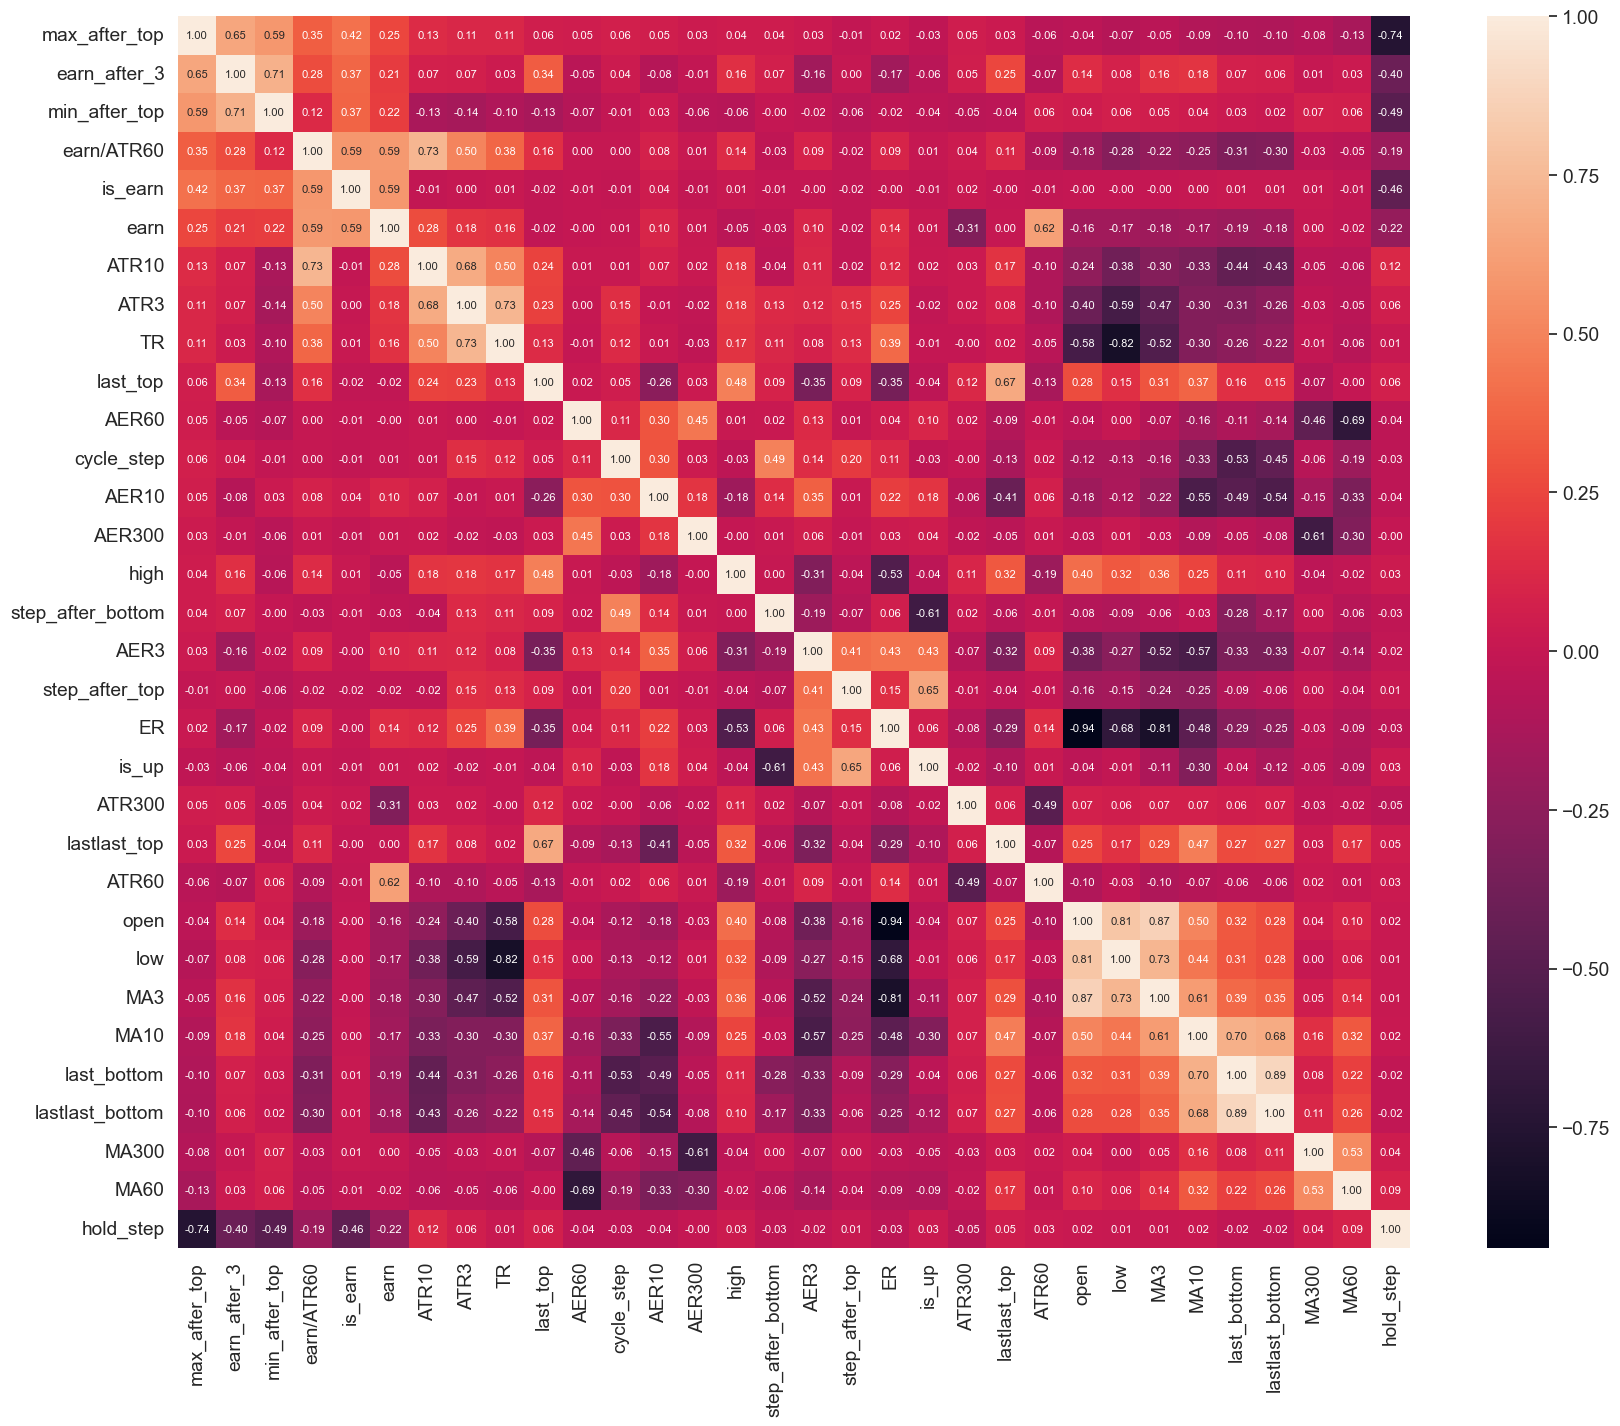

In [66]:
heatmap_data = full_data.df.iloc[:, :].copy()

target.reset_target(3)
target.drop_others(heatmap_data)
heatmap_data[target.target_name()] = heatmap_data[target.target_name()] / heatmap_data['ATR60']
# drop_col(heatmap_data, [target.target_name()])

base_atr = 'ATR60'

heatmap_data['earn/ATR60'] = heatmap_data['earn'] / heatmap_data['ATR60']
heatmap_data['max_after_top'] = heatmap_data['max_after_top'] / heatmap_data[base_atr]
heatmap_data['min_after_top'] = heatmap_data['min_after_top'] / heatmap_data[base_atr]


outlire_value = 10
outlire_idx = heatmap_data[heatmap_data['max_after_top'] > outlire_value].index
heatmap_data.loc[outlire_idx, 'max_after_top'] = outlire_value

for feat in price_feats:
    heatmap_data[feat] = (heatmap_data[feat] - 1) / heatmap_data[base_atr]

for feat in dprice_feats:
    heatmap_data[feat] = heatmap_data[feat] / heatmap_data[base_atr]

for feat in (tr_feats - {base_atr}):
    heatmap_data[feat] = heatmap_data[feat] / heatmap_data[base_atr]

# for feat in (vol_feats - {'AQAV60'}):
#     heatmap_data[feat] = heatmap_data[feat] / heatmap_data['AQAV60']

# for feat in (voltr_feats - {'AVT60'}):
#     heatmap_data[feat] = heatmap_data[feat] / heatmap_data['AVT60']
    
# for feat in (tn_feats - {'AT60'}):
#     heatmap_data[feat] = heatmap_data[feat] / heatmap_data['AT60']


heatmap_data.replace([np.inf, -np.inf], np.nan, inplace=True)
heatmap_data.dropna(axis=0, how='any', inplace=True)

# drop_col(heatmap_data, price_feats - {max_100, min_100})
# drop_col(heatmap_data, dprice_feats)
# drop_col(heatmap_data, tr_feats)
drop_col(heatmap_data, tn_feats)
# drop_col(heatmap_data, vol_feats)
# drop_col(heatmap_data, set(full_data.cols_of_features([FeatTypes.OTHERS])))

# heatmap_data['ave_after_top'] = (heatmap_data['max_after_top'] + heatmap_data['min_after_top']) / 2
target_name = 'max_after_top'
# max_loss_idx = heatmap_data[heatmap_data['earn/ATR60'] < -0.5001].index
# print(len(max_loss_idx))

heatmap_font(heatmap_data.iloc[:, :].loc[:, :], target=target_name)

up_idx = heatmap_data[heatmap_data['is_up'] == 1].index
down_idx = heatmap_data[heatmap_data['is_up'] == 0].index
drop_col(heatmap_data, ['is_up'])

In [7]:
# up_loss_idx = [idx for idx in max_loss_idx if idx in up_idx]
# print(len(up_loss_idx))
# heatmap_font(heatmap_data.loc[up_idx, :], target=target_name)
# heatmap_data.loc[up_loss_idx].head()

In [8]:
# down_loss_idx = [idx for idx in max_loss_idx if idx in down_idx]
# print(len(down_loss_idx))
# heatmap_font(heatmap_data.loc[down_idx, :], target=target_name)
# heatmap_data.loc[down_loss_idx].head()

In [9]:
full_data.df.head(10)

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,hold_step,earn,earn_after_3,is_earn,max_after_top,min_after_top,ER,lastlast_top,lastlast_bottom,MA3,MA10,MA60,MA300,ATR3,ATR10,ATR60,ATR300,AER3,AER10,AER60,AER300
314,0.999745,1.000017,0.999642,0.000375,1.000051,3.0,0.997184,10.0,0.0,7.0,0.0,0.000269,-0.000389,1,0.000635,-0.000580,0.678851,1.001215,0.997184,0.999880,0.999475,0.999218,1.001582,0.000442,0.000536,0.000747,0.001000,0.228671,0.262959,0.068217,-0.003255
325,0.999401,1.000005,0.999384,0.000621,1.000969,10.0,0.998927,4.0,1.0,6.0,1.0,0.000310,0.001043,1,0.000409,-0.000328,0.963729,1.000969,0.998927,0.999647,0.999660,0.999797,1.001412,0.000496,0.000619,0.000639,0.000993,0.350747,-0.027674,0.041494,-0.001152
344,0.999728,1.000132,0.999688,0.000444,1.000268,4.0,0.999204,7.0,0.0,3.0,0.0,0.000295,0.001367,1,0.001099,0.000204,0.612378,1.000268,0.999204,0.999909,0.999827,0.999915,1.000736,0.000526,0.000589,0.000678,0.000985,0.216498,-0.036003,0.029926,0.007880
418,0.999104,1.000137,0.998596,0.001541,1.000312,7.0,0.997586,11.0,0.0,4.0,9.0,0.000476,-0.000032,1,0.000363,-0.000375,0.581310,1.000312,0.997586,0.999518,0.999494,1.001771,1.004315,0.001026,0.000950,0.000825,0.000810,0.150159,-0.046732,-0.124715,-0.013683
433,0.999967,1.000027,0.999855,0.000172,1.000109,4.0,0.997767,8.0,0.0,4.0,21.0,0.000286,0.000012,1,0.000042,-0.000745,0.192348,1.000109,0.997767,0.999856,0.999386,0.999878,1.003063,0.000424,0.000572,0.000816,0.000791,0.221597,0.301607,-0.076562,-0.013112
487,0.999925,1.000230,0.999859,0.000370,1.000906,12.0,0.999231,6.0,1.0,6.0,0.0,0.000273,0.001163,1,0.001071,0.000206,0.201553,1.000906,0.999231,0.999944,0.999797,1.000705,1.003059,0.000417,0.000544,0.000615,0.000743,0.107943,0.092715,-0.015041,-0.022170
502,0.999961,1.000134,0.999950,0.000184,1.000316,14.0,0.998593,8.0,1.0,6.0,2.0,0.000255,0.000341,1,0.000290,-0.000238,0.211004,1.000316,0.998593,0.999939,0.999511,0.999106,1.001128,0.000368,0.000509,0.000638,0.000741,0.199742,0.126141,-0.018628,-0.028681
553,1.000187,1.000371,0.999843,0.000529,1.000576,5.0,0.999383,4.0,1.0,1.0,2.0,0.000291,0.000613,1,0.000307,-0.000592,-0.353970,1.000576,0.999383,1.000027,1.000059,1.000636,1.001366,0.000525,0.000582,0.000526,0.000678,0.088657,-0.034914,0.034620,-0.009849
616,1.000359,1.000549,0.999932,0.000618,1.000759,10.0,0.999668,8.0,1.0,2.0,3.0,0.000273,0.000844,1,0.000145,-0.000350,-0.580649,1.000759,0.999668,1.000215,1.000302,1.001027,1.000598,0.000530,0.000545,0.000535,0.000634,-0.246416,-0.083286,0.010560,-0.021803
625,0.999757,1.000000,0.999426,0.000574,1.000063,4.0,0.998560,17.0,0.0,13.0,2.0,0.000253,0.000152,1,0.000293,-0.000063,0.423026,1.000063,0.998560,0.999865,0.999676,0.999925,0.999444,0.000419,0.000505,0.000514,0.000630,0.222618,0.093601,-0.011715,-0.015722


In [60]:
heatmap_data.head(10)

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,cycle_step,hold_step,earn,earn_after_3,is_earn,max_after_top,min_after_top,ER,lastlast_top,lastlast_bottom,MA3,MA10,MA60,MA300,ATR3,ATR10,ATR60,ATR300,AER3,AER10,AER60,AER300,earn/ATR60
314,-0.340912,0.023310,-0.478831,0.502189,0.068474,3.0,-3.770912,10.0,7.0,0.0,0.000269,-0.000389,1,0.850823,-0.776036,0.678851,1.627344,-3.770912,-0.160581,-0.703531,-1.046693,2.118312,0.591545,0.718246,0.000747,1.338633,0.228671,0.262959,0.068217,-0.003255,0.359768
325,-0.936276,0.007944,-0.963514,0.971514,1.516200,10.0,-1.679056,4.0,6.0,1.0,0.000310,0.001043,1,0.640073,-0.513533,0.963729,1.516200,-1.679056,-0.552876,-0.532145,-0.317804,2.208018,0.776315,0.968167,0.000639,1.553958,0.350747,-0.027674,0.041494,-0.001152,0.484837
344,-0.400956,0.194857,-0.459842,0.654753,0.396139,4.0,-1.173962,7.0,3.0,0.0,0.000295,0.001367,1,1.621491,0.301386,0.612378,0.396139,-1.173962,-0.134723,-0.255831,-0.125828,1.086428,0.775736,0.869310,0.000678,1.453072,0.216498,-0.036003,0.029926,0.007880,0.435366
418,-1.085212,0.165937,-1.700857,1.866838,0.377772,7.0,-2.925086,11.0,4.0,9.0,0.000476,-0.000032,1,0.439557,-0.455003,0.581310,0.377772,-2.925086,-0.584605,-0.613438,2.146446,5.228686,1.243838,1.151543,0.000825,0.981407,0.150159,-0.046732,-0.124715,-0.013683,0.576355
433,-0.040591,0.033454,-0.177529,0.211028,0.133816,4.0,-2.737877,8.0,4.0,21.0,0.000286,0.000012,1,0.051296,-0.913518,0.192348,0.133816,-2.737877,-0.176935,-0.752492,-0.149487,3.754965,0.519846,0.700929,0.000816,0.970050,0.221597,0.301607,-0.076562,-0.013112,0.351055
487,-0.121329,0.373457,-0.228454,0.601971,1.472523,12.0,-1.248804,6.0,6.0,0.0,0.000273,0.001163,1,1.740040,0.334987,0.201553,1.472523,-1.248804,-0.091342,-0.329305,1.145723,4.970340,0.677925,0.884283,0.000615,1.207649,0.107943,0.092715,-0.015041,-0.022170,0.442925
502,-0.060957,0.210216,-0.078618,0.288891,0.495632,14.0,-2.204140,8.0,6.0,2.0,0.000255,0.000341,1,0.454045,-0.373148,0.211004,0.495632,-2.204140,-0.095708,-0.765780,-1.400845,1.766779,0.576586,0.797000,0.000638,1.161027,0.199742,0.126141,-0.018628,-0.028681,0.399255
553,0.355935,0.706330,-0.299152,1.005551,1.095505,5.0,-1.173062,4.0,1.0,2.0,0.000291,0.000613,1,0.583761,-1.125974,-0.353970,1.095505,-1.173062,0.050551,0.111559,1.210087,2.598887,0.999781,1.107346,0.000526,1.290526,0.088657,-0.034914,0.034620,-0.009849,0.554590
616,0.670528,1.026873,-0.127849,1.154790,1.419261,10.0,-0.620884,8.0,2.0,3.0,0.000273,0.000844,1,0.270659,-0.654887,-0.580649,1.419261,-0.620884,0.401455,0.565324,1.920582,1.117270,0.990445,1.019393,0.000535,1.184658,-0.246416,-0.083286,0.010560,-0.021803,0.510597
625,-0.471890,0.000000,-1.115441,1.115512,0.121505,4.0,-2.799553,17.0,13.0,2.0,0.000253,0.000152,1,0.568670,-0.121505,0.423026,0.121505,-2.799553,-0.262083,-0.630765,-0.146677,-1.079955,0.813634,0.981645,0.000514,1.223941,0.222618,0.093601,-0.011715,-0.015722,0.491759


In [68]:
temp = heatmap_data[:] # (heatmap_data['MA60'] > -0.2) & (heatmap_data['MA60'] <= -0.1)
total = len(temp)
max_at = temp['max_after_top']
min_at = temp['min_after_top']
earn_after_3 = temp["earn_after_3"]

print(f"total: {total}")
# histplot(max_at)
# histplot(min_at)

high_th = 0.5
low_th = -5
# for high_th in np.arange(0, 5.1, 0.5):
#      for low_th in np.arange(0, -5.1, -0.5):
print(f"high_th: {high_th}, low_th: {low_th}")
both_num = sum((max_at >= high_th) & (min_at <= low_th))
exit_num = sum((max_at >= high_th) & (min_at >  low_th))
stop_num = sum((max_at <  high_th) & (min_at <= low_th))
left_num = total - both_num - exit_num - stop_num
print(f"both num: {both_num}, exit num: {exit_num}, stop num: {stop_num}, left num: {left_num}")

if left_num > 0:
     left_idx = (max_at <  high_th) & (min_at > low_th)
     mean_left = earn_after_3[left_idx].mean()
else:
     mean_left = 0
print(f"mean_left: {mean_left}")

earn = left_num * mean_left \
     + exit_num * high_th \
     + stop_num * low_th  \

print(f"Ave earn: {earn / total_num : .5f}")

total: 2921
high_th: 0.5, low_th: -5
both num: 2, exit num: 1758, stop num: 2, left num: 1159
mean_left: -0.0028841036640765644
Ave earn:  0.29514


In [70]:
for low_th in np.arange(0, -5.1, -0.5):
    unstop_idx = (min_at >  low_th)
    unstop_num = sum(unstop_idx)
    stop_loss = low_th * (total - unstop_num)
    unstop_earn = earn_after_3[unstop_idx].mean() * unstop_num
    print(f"low_th: {low_th}, earn: {stop_loss + unstop_earn}, stop_loss: {stop_loss}, unstop_earn: {unstop_earn}")

low_th: 0.0, earn: 966.2155862835646, stop_loss: 0.0, unstop_earn: 966.2155862835646
low_th: -0.5, earn: 1031.3992769295614, stop_loss: -843.5, unstop_earn: 1874.8992769295614
low_th: -1.0, earn: 1488.234610816446, stop_loss: -846.0, unstop_earn: 2334.234610816446
low_th: -1.5, earn: 1802.5769719601258, stop_loss: -553.5, unstop_earn: 2356.076971960126
low_th: -2.0, earn: 1964.801469070475, stop_loss: -326.0, unstop_earn: 2290.801469070475
low_th: -2.5, earn: 2040.2330212270135, stop_loss: -207.5, unstop_earn: 2247.7330212270135
low_th: -3.0, earn: 2082.6545870674186, stop_loss: -120.0, unstop_earn: 2202.6545870674186
low_th: -3.5, earn: 2096.9092776253474, stop_loss: -73.5, unstop_earn: 2170.4092776253474
low_th: -4.0, earn: 2108.1614900211853, stop_loss: -44.0, unstop_earn: 2152.1614900211853
low_th: -4.5, earn: 2116.6416757368415, stop_loss: -31.5, unstop_earn: 2148.1416757368415
low_th: -5.0, earn: 2118.728798840756, stop_loss: -20.0, unstop_earn: 2138.728798840756


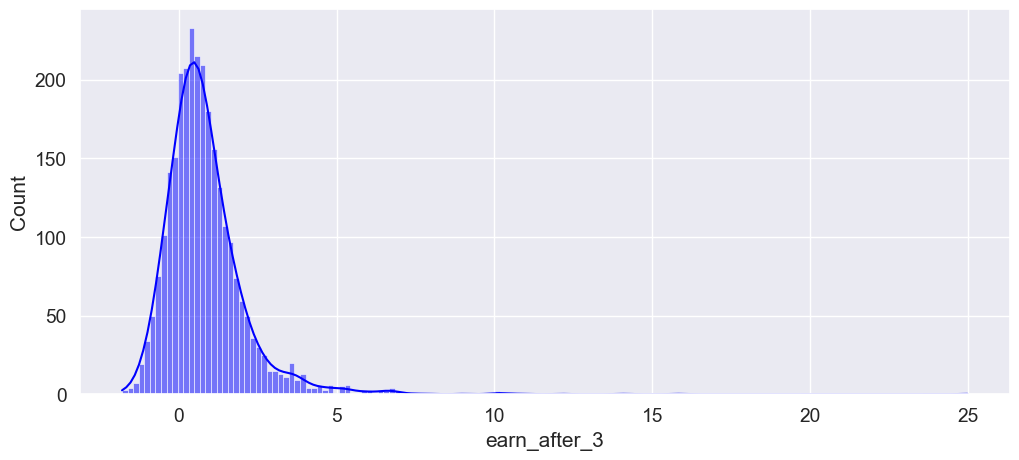

0.8306024180821157

In [69]:
unstop_idx = (min_at >  -2)
histplot(earn_after_3[unstop_idx])
earn_after_3[unstop_idx].mean()

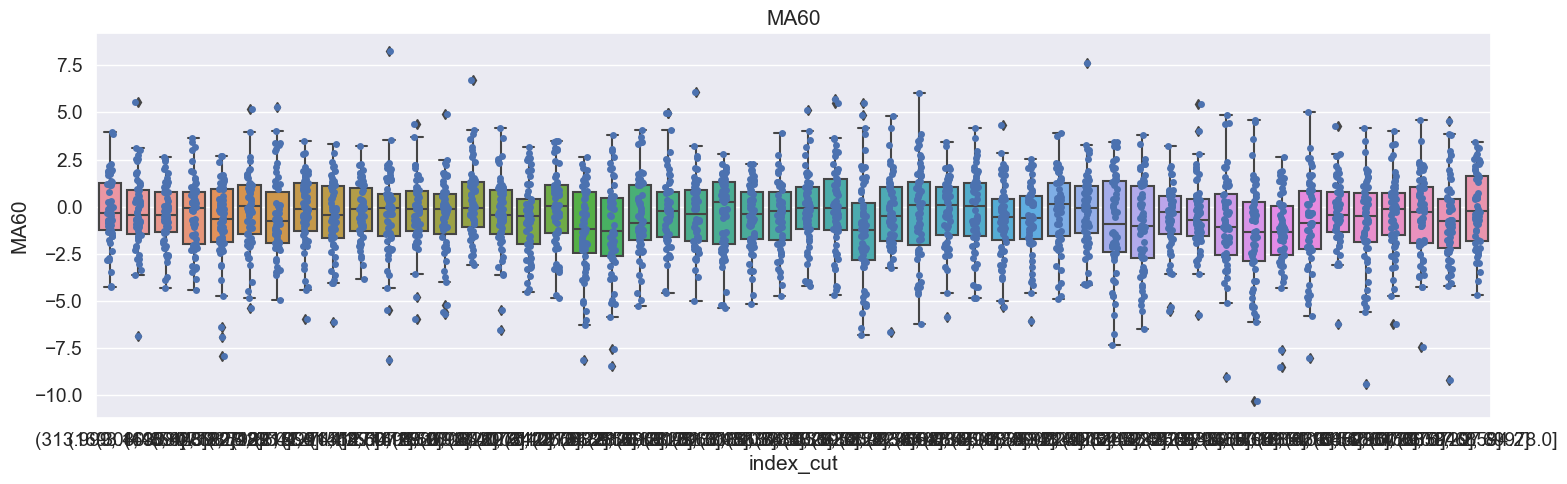

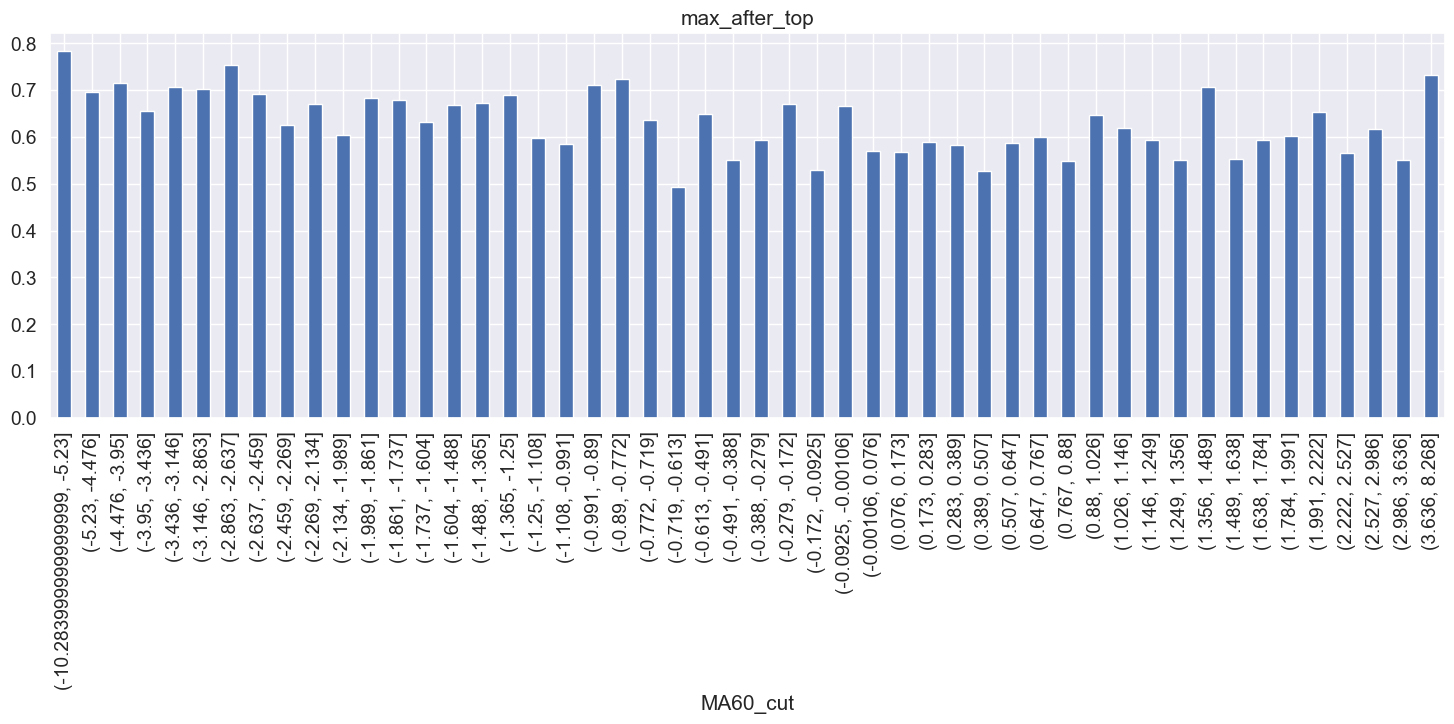

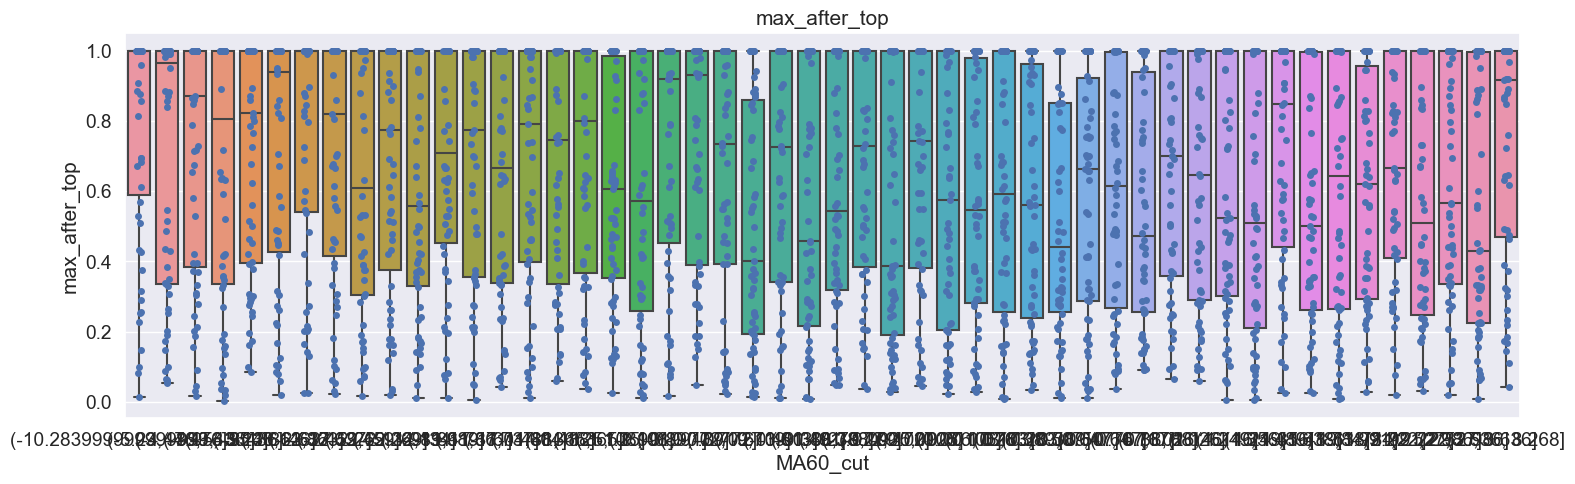

In [28]:

plot_data = heatmap_data.loc[:, :].copy()
plot_data['index'] = plot_data.index
checked = 'MA60'
bias = 0

# plt_A_B(plot_data, 'index', 'ATR10', cut_num=10)
# plt_A_B(plot_data, 'index', 'earn/ATR10', cut_num=10)
# plt_A_B(plot_data, 'index', 'ATR10', cut_num=10)

# plt_A_B(plot_data, 'index', checked, cut_num=10, bias=bias)
plt_box_A_B(plot_data, 'index', checked, cut_num=50)

plt_A_B(plot_data, checked, target_name, cut_num=50)
plt_box_A_B(plot_data, checked, target_name, cut_num=50)

In [17]:
heatmap_data[heatmap_data[target_name] >= 15]

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,cycle_step,hold_step,earn,is_earn,max_after_top,min_after_top,ER,lastlast_top,lastlast_bottom,MA3,MA10,MA60,MA300,ATR3,ATR10,ATR60,ATR300,AER3,AER10,AER60,AER300,earn/ATR60
24730,-0.286423,0.220979,-0.388413,0.609477,0.229478,3.0,-4.004816,10.0,7.0,0.0,0.000197,1,15.947872,0.003450,0.469948,-2.095899,-4.004816,-0.386713,-1.493477,-1.318436,-5.755821,0.813740,0.896154,0.000438,0.759850,0.222459,0.293393,0.025525,0.040474,0.449176
25791,-0.580758,1.112410,-0.601303,1.713763,1.362953,3.0,-5.775514,15.0,12.0,0.0,0.000550,1,15.563721,0.000350,0.338879,-3.603307,-5.775514,-0.375313,-1.655437,-5.132905,-8.951749,1.453032,1.510874,0.000727,0.674493,0.242077,0.267522,0.129966,0.051641,0.756099
31461,-0.244665,0.383492,-0.324387,0.707948,0.696196,13.0,-3.616371,4.0,9.0,0.0,0.000323,1,15.646885,0.003250,0.345598,0.696196,-3.616371,-0.357376,-1.196248,2.255787,3.207663,0.841277,1.189306,0.000542,1.137150,0.225931,0.044319,0.018970,-0.022660,0.595542
36104,-0.466037,0.035537,-1.004163,1.039801,0.219312,3.0,-7.452533,13.0,10.0,0.0,0.000256,1,16.733679,-0.000152,0.448198,-6.102142,-7.452533,-0.792297,-2.027109,-3.913274,-4.790889,1.680475,1.415474,0.000361,0.831025,0.202401,0.376468,-0.006022,0.011635,0.709071
53830,-0.623004,0.110852,-0.659095,0.770033,0.984776,11.0,-1.972130,5.0,6.0,0.0,0.000167,1,34.597769,0.000111,0.809061,0.984776,-1.972130,-0.322243,-0.758260,-2.488320,-8.273620,0.854246,0.751729,0.000442,0.927222,0.278352,0.072860,0.043765,0.018803,0.376953


In [35]:
# heatmap_data['ATR10'].mean()
heatmap_data['AER10'].mean()

0.25180949334818037

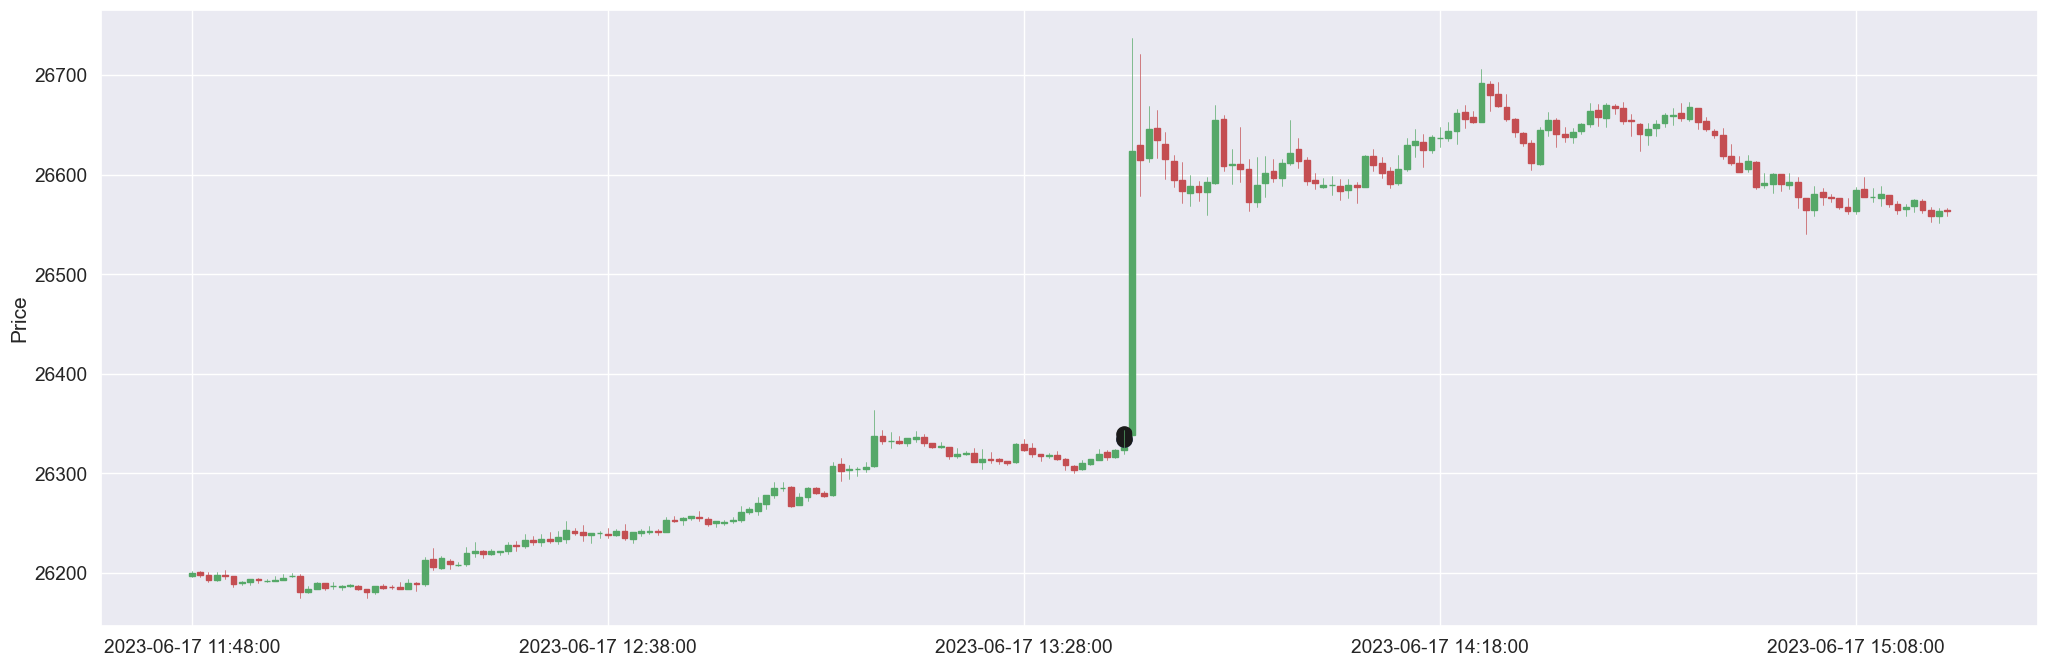

In [25]:
# idx = heatmap_data[(heatmap_data['high'] > 0.4)].index
# print(len(idx))
start = 53830      
# print(f"high: {heatmap_data.loc[start, 'earn/ATR60']}")
last_top_idx = start - sim_data.loc[start, 'step_after_top']
sell_idx = sim_data.loc[start, 'hold_step'] + start + 1
points = [PricePlot.Points(start+1, sim_data.loc[start, 'last_top'], s=120, c='b', label='default'),
          PricePlot.Points(sell_idx, sim_data.loc[start, 'sell_price'], s=120, c='k', label='default'),
          PricePlot.Points(start+1, sim_data.loc[start, 'buy_price'], s=120, c='k', label='default')]
plot(sim_data, last_top_idx-100, start+100, points)

In [66]:
heatmap_data[heatmap_data['AER10'] > 0.4]

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,cycle_step,hold_step,earn,is_earn,max_after_top,min_after_top,ER,lastlast_top,lastlast_bottom,MA3,MA10,MA60,MA300,ATR3,ATR10,ATR60,ATR300,AER3,AER10,AER60,AER300,earn/ATR10,ave_after_top
5916,-0.563238,0.180649,-0.563238,0.743908,0.310866,3.0,-4.844257,10.0,7.0,14.0,-0.002572,0,0.000109,-0.002011,0.757134,-4.303962,-4.844257,-0.537883,-2.321593,-4.985972,-6.510988,1.188848,0.001714,0.402675,0.246243,0.250085,0.448643,0.050170,0.017125,-1.500844,-0.000951
16422,0.093853,0.608970,-0.320963,0.930004,0.645508,3.0,-4.475570,10.0,7.0,2.0,0.000233,1,0.000271,-0.000261,-0.100917,-2.223814,-4.475570,0.031762,-1.056455,-1.341166,13.861365,0.734656,0.000465,1.267051,1.528524,0.044293,0.405142,0.017114,-0.002235,0.501039,0.000005
18077,-1.288129,0.169988,-1.290018,1.460100,2.993673,27.0,-5.116630,9.0,18.0,0.0,0.000179,1,0.000376,-0.001230,0.882220,2.993673,-5.116630,-1.138918,-3.221645,-3.219300,-11.691305,1.420122,0.000358,1.492791,1.565049,0.858768,0.432478,0.089521,0.064085,0.501350,-0.000427
36032,-0.331741,0.143300,-0.542229,0.685581,0.478715,13.0,-4.922051,9.0,4.0,0.0,0.000322,1,0.000693,-0.000060,0.483883,0.478715,-4.922051,-0.530856,-2.052753,-1.075044,-9.517801,1.026945,0.000642,1.481917,1.475424,0.419707,0.400749,0.008395,0.042138,0.500752,0.000316
36944,-0.987664,0.000757,-1.142057,1.142890,0.267918,15.0,-5.133581,10.0,5.0,0.0,0.000233,1,0.000239,-0.001075,0.864181,0.267918,-5.133581,-0.647342,-1.741240,2.511163,-10.945241,0.826787,0.000465,1.139623,1.374061,0.142713,0.447838,-0.072717,0.029505,0.501037,-0.000418
71254,-0.279886,0.212871,-0.393220,0.606189,0.477974,5.0,-5.529713,12.0,7.0,0.0,0.000194,1,0.000343,-0.000418,0.461714,0.477974,-5.529713,-0.415229,-1.187642,-2.293683,-0.395605,0.851582,0.000387,1.380572,1.908390,0.285357,0.404085,0.041236,-0.008251,0.501242,-0.000037
